In [1]:
import numpy as np
import pandas as pd
import statistics as stats
import matplotlib
from matplotlib import pylab as plt

# Classification - target variable: rating
df = pd.read_csv('../data/sephora_website_dataset.csv')
# Drop 'MarketingFlags_content' becasue it has redundant information
df = df[df.columns.difference(['options', 'details', 'how_to_use', 'ingredients', 'URL','MarketingFlags_content','id','name','brand'])]
print(df.shape)
df.head()

(9168, 12)


,MarketingFlags,category,exclusive,limited_edition,limited_time_offer,love,number_of_reviews,online_only,price,rating,size,value_price
0,True,Fragrance,0,0,0,3002,4,1,66.0,4.0,5 x 0.16oz/5mL,75.0
1,True,Cologne,0,0,0,2700,76,1,66.0,4.5,0.7 oz/ 20 mL,66.0
2,True,Perfume,0,0,0,2600,26,1,180.0,4.5,5 oz/ 148 mL,180.0
3,True,Perfume,0,0,0,2900,23,1,120.0,4.5,2.5 oz/ 74 mL,120.0
4,True,Fragrance,0,0,0,943,2,1,72.0,3.5,5 x 0.16oz/5mL,80.0


In [2]:
len(df['category'].unique())

143

In [3]:
# Convert 'size' into usable information
def convert_size(size):
    if 'x' in size:
        return np.nan
    elif 'fl' in size or 'g' in size or 'Vials' in size or 'Mini' in size or 'Glitter' in size or 'Jumbo' in size:
        return np.nan
    elif ' oz' in size:
        return float(size.strip().split('/')[0].split(' ')[0])
    elif 'oz' in size:
        return float(size.strip().split('oz')[0])
    else: 
        return np.nan
    
df['liquid_size'] = [convert_size(df['size'][i]) for i in range(df.shape[0])]
df['unit_price'] = df['price']/df['liquid_size']

In [4]:
# Extraxt categorical columns
def cat_cols(df, col = df.columns):
    cat = []
    for name in col:
        if len(df[name].value_counts()) < 3:
            cat.append(name)
    return cat

In [5]:
categorical_cols = cat_cols(df)
categorical_cols.append('rating')

In [6]:
# Extraxt continuous columns
continuous_cols = list(df[df.columns.difference(categorical_cols)].columns)

False    4786
True     4382
Name: MarketingFlags, dtype: int64


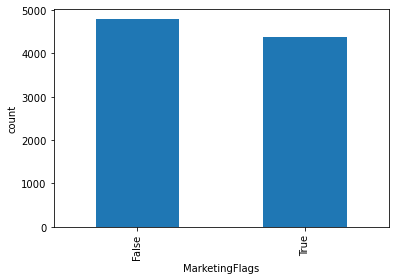

0    6741
1    2427
Name: exclusive, dtype: int64


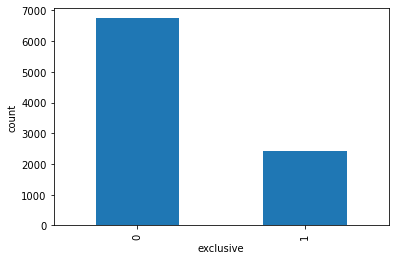

0    8326
1     842
Name: limited_edition, dtype: int64


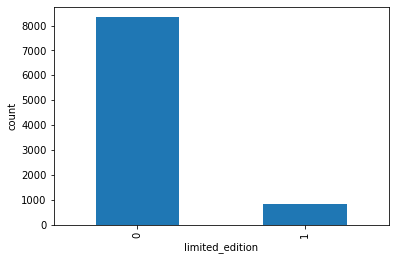

0    9165
1       3
Name: limited_time_offer, dtype: int64


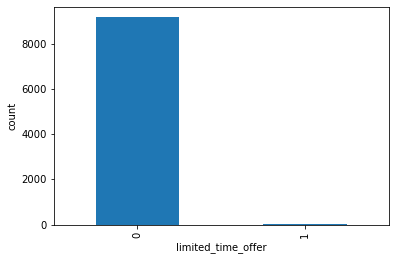

0    7015
1    2153
Name: online_only, dtype: int64


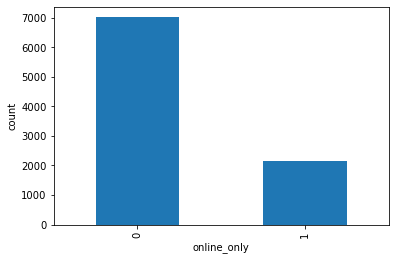

4.5    3527
4.0    2853
3.5    1051
5.0     872
0.0     398
3.0     308
2.5      88
2.0      39
1.0      23
1.5       9
Name: rating, dtype: int64


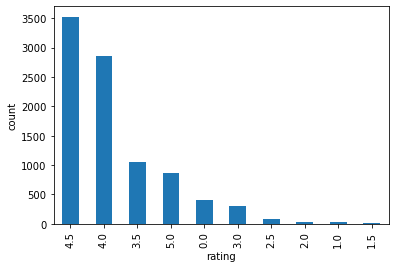

In [7]:
# categorical
from matplotlib.pyplot import figure

for col in categorical_cols:
    print(df[col].value_counts())
    pd.value_counts(df[col]).plot.bar()
    plt.ylabel('count')
    plt.xlabel(col)
    plt.savefig('../figures/'+str(col)+'.jpg', dpi=300)
    plt.show()

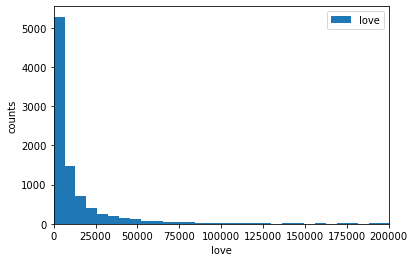

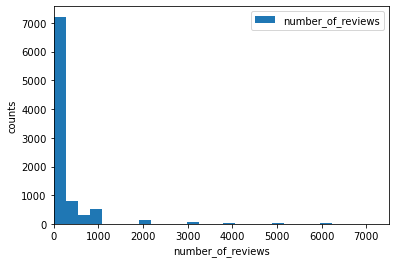

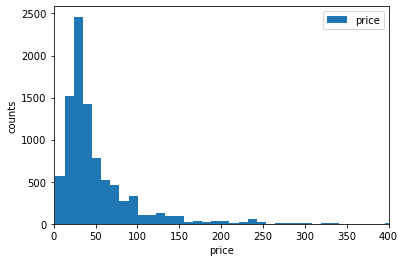

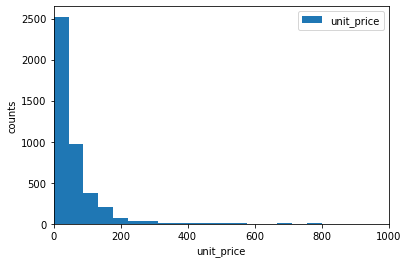

In [8]:
continuous_cols = [ 'love', 'number_of_reviews', 'price', 'unit_price']
df['love'].plot.hist(bins = 200, xlim=(0.0, 200000))
plt.legend()
plt.ylabel('counts')
plt.xlabel('love')
plt.savefig('../figures/love.jpg', dpi=300)
plt.show()

df['number_of_reviews'].plot.hist(bins = 70, xlim=(0, 7500))
plt.legend()
plt.ylabel('counts')
plt.xlabel('number_of_reviews')
plt.savefig('../figures/number_of_reviews.jpg', dpi=300)
plt.show()

df['price'].plot.hist(bins = 50, xlim=(0, 400))
plt.legend()
plt.ylabel('counts')
plt.xlabel('price')
plt.savefig('../figures/price.jpg', dpi=300)
plt.show()


df['unit_price'].plot.hist(bins = 100, xlim=(0, 1000))
plt.legend()
plt.ylabel('counts')
plt.xlabel('unit_price')
plt.savefig('../figures/unit_price.jpg', dpi=300)
plt.show()

In [9]:
# Since the data is highly imbalanced, we cannot observe any useful information from scatter matrix
# pd.plotting.scatter_matrix(df.select_dtypes(int), figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, s=30, alpha=.1)
# plt.savefig('../figures/scatter_matrix.jpg', dpi=300)
# plt.show()

In [10]:
# Categorical vs Categorical
# Stacked bar plot: price vs category
mean_price = stats.mean(df['price'])
price = df['price']
price_level = []
for i in price:
    if i<50:
        price_level.append('<50')
    else:
        price_level.append('>=50')
new_df = df
new_df['price_level']= price_level 

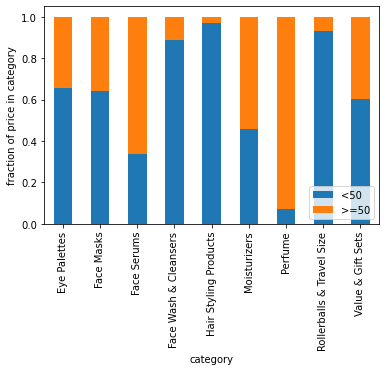

In [11]:
category = new_df['category'].value_counts()
df_cat = new_df.loc[df['category'].isin(list(category[category>200].index))]
count_matrix = df_cat.groupby(['category', 'price_level']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of price in category')
plt.legend(loc=4)
plt.savefig('../figures/stacked_bar_plot.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

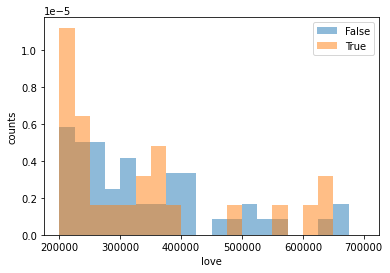

In [12]:
new_df = df[df['love']>100000]
categories = new_df['MarketingFlags'].unique()
bin_range = (200000,700000)

for c in categories:
    plt.hist(df[df['MarketingFlags']==c]['love'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('love')
plt.savefig('../figures/compared_histogram.jpg', dpi=300)
plt.show()

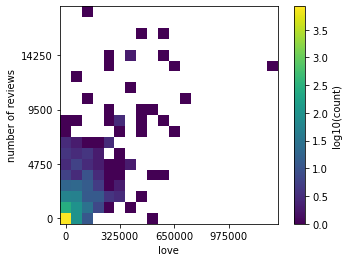

In [13]:
nbins = 20
heatmap, xedges, yedges = np.histogram2d(df['love'], df['number_of_reviews'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

np.seterr(divide = 'ignore') 
plt.imshow(np.log10(heatmap).T, origin='lower') # use log count
plt.xlabel('love')
plt.ylabel('number of reviews')
plt.xticks(np.arange(nbins)[::int(nbins/4)],xedges[::int(nbins/4)].astype(int))
plt.yticks(np.arange(nbins)[::int(nbins/4)],yedges[::int(nbins/4)].astype(int))
plt.colorbar(label='log10(count)')
plt.savefig('../figures/heatmap.png', dpi=300)
plt.show()

In [18]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
perc_missing_per_ftr

data dimensions: (9168, 15)


MarketingFlags        0.00000
category              0.00000
exclusive             0.00000
limited_edition       0.00000
limited_time_offer    0.00000
love                  0.00000
number_of_reviews     0.00000
online_only           0.00000
price                 0.00000
rating                0.00000
size                  0.00000
value_price           0.00000
liquid_size           0.52836
unit_price            0.52836
price_level           0.00000
dtype: float64

In [19]:
from statistics import mean
import math
# helper function for MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    sum = 0; 
    count = 0; 
    for i in range(len(y_true)):
        if (y_true[i]>0):
           sum += abs(y_true[i]-y_pred[i])/ y_true[i] 
           count += 1 
    return round(sum/count, 3)

In [28]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import TweedieRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# let's separate the feature matrix X, and target variable y
df2 = df[df_cat.columns.difference(['brand', 'id', 'name', 'size', 'value_price', 'price_level', 'unit_price'])]
X = df2.loc[:,df2.columns!='rating']
y = df2.loc[:,df2.columns=='rating']
random_state = 63

# collect which encoder to use on each feature
std_ftrs = ['love', 'number_of_reviews', 'price']
onehot_ftrs = ['MarketingFlags', 'category', 'exclusive', 'limited_edition', 'limited_time_offer','online_only']

# collect all the encoders
preprocessor = ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                               ('std', StandardScaler(), std_ftrs)])
clf = Pipeline(steps=[('preprocessor', preprocessor)])

# split to separate out the training, validation and testing set
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
print('test balance:',y_test['rating'].value_counts(normalize=True))

kf = KFold(n_splits=5,shuffle=True,random_state=random_state)


for train_index, val_index in kf.split(X_other,y_other):
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]

    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)
    
    y_train_prep = y_train.values.ravel()
    y_val_prep = y_val.values.ravel()
    y_test_prep = y_test.values.ravel()
    
    # print("training set:", X_train_prep.shape) 
    # print("validation set:", X_val_prep.shape) 
    # print("test set:", X_test_prep.shape) 
    
    # reg = linear_model.LinearRegression()
    # coef = reg.coef_
    # reg = linear_model.Ridge(alpha=.5)
    # reg = linear_model.Lasso(alpha=0.1)
    # reg = TweedieRegressor(power=1, alpha=0.5, link='log')
    # reg = KNeighborsRegressor(n_neighbors=17)
    # reg = tree.DecisionTreeRegressor()
    # reg = MLPRegressor(random_state=1, max_iter=500)
    # reg = svm.SVR()
    reg = RandomForestRegressor()
    reg.fit(X_train_prep, y_train_prep)
    y_val_pred = reg.predict(X_val_prep)
    r_squared = r2_score(y_val_prep,y_val_pred)
    cur_rmse = math.sqrt(mean_squared_error(y_val_prep,y_val_pred))
    cur_mape = mean_absolute_percentage_error(y_val_prep, y_val_pred)
    round(r_squared, 3), round(cur_rmse, 3), round(cur_mape, 3)

test balance: 4.5    0.354417
4.0    0.309160
3.5    0.121592
5.0    0.103053
0.0    0.053980
3.0    0.037077
2.5    0.012541
2.0    0.005998
1.0    0.002181
Name: rating, dtype: float64


# Select and Train Model

In [29]:
# SVR: (0.04, 0.961, 0.098)
# Linear Regression: (0.048, 0.957, 0.114)
# Ridge: (0.05, 0.956, 0.113)
# Lasso: (-0.002, 0.982, 0.107)
# Bayesian: (0.06, 0.951, 0.112)
# GLM: (0.033, 0.965, 0.113)
# KNN: (0.082, 0.94, 0.111)
# Decision Tree: (0.525, 0.676, 0.12)
# Randome Forest: (0.727, 0.513, 0.108)
# MLP: (-0.008, 0.985, 0.131)

# Fine-tune the model

In [30]:
from sklearn.model_selection import GridSearchCV
 
param_grid = {"gamma":[0.001,0.01,0.1,1,10,100,1000],
             "C":[0.001,0.01,0.1,1,10,100]}
print("Parameters:{}".format(param_grid))
 
grid_search = GridSearchCV(svm.SVR(),param_grid,cv=5)
grid_search.fit(X_train_prep, y_train_prep)
print("Test set score:{:.2f}".format(grid_search.score(X_test_prep,y_test_prep)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Parameters:{'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}


KeyboardInterrupt: 

In [ ]:
pipe_tree.get_params().keys()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
clf = svm.SVR(gamma = 0.1, C = 10)
reg = clf.fit(X_train_prep, y_train_prep)
y_val_pred = clf.predict(X_val_prep)
r_squared = r2_score(y_val_prep,y_val_pred)
cur_rmse = math.sqrt(mean_squared_error(y_val_prep,y_val_pred))
cur_mape = mean_absolute_percentage_error(y_val_prep, y_val_pred)
round(r_squared, 3), round(cur_rmse, 3), round(cur_mape, 3)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
param_grid = {'decisiontreeregressor__max_depth': np.linspace(1, 32, 32, endpoint=True),
              'decisiontreeregressor__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
              'decisiontreeregressor__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True)}
print("Parameters:{}".format(param_grid))
 
pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=42))    
grid_search = GridSearchCV(pipe_tree,param_grid,cv=5)
grid_search.fit(X_train_prep, y_train_prep)
print("Test set score:{:.2f}".format(grid_search.score(X_test_prep,y_test_prep)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

In [ ]:
clf = tree.DecisionTreeRegressor(max_depth = 5.0, min_samples_leaf = 1, min_samples_split = 0.1)
reg = clf.fit(X_train_prep, y_train_prep)
y_val_pred = clf.predict(X_val_prep)
r_squared = r2_score(y_val_prep,y_val_pred)
cur_rmse = math.sqrt(mean_squared_error(y_val_prep,y_val_pred))
cur_mape = mean_absolute_percentage_error(y_val_prep, y_val_pred)
round(r_squared, 3), round(cur_rmse, 3), round(cur_mape, 3)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
param_grid = { 'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth' : [int(x) for x in np.linspace(1, 100, num = 20)]}
print("Parameters:{}".format(param_grid))
 
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5)
grid_search.fit(X_train_prep, y_train_prep)
print("Test set score:{:.2f}".format(grid_search.score(X_test_prep,y_test_prep)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

In [ ]:
clf = RandomForestRegressor(max_features = 'auto', max_depth = 16)
reg = clf.fit(X_train_prep, y_train_prep)
y_val_pred = clf.predict(X_val_prep)
r_squared = r2_score(y_val_prep,y_val_pred)
cur_rmse = math.sqrt(mean_squared_error(y_val_prep,y_val_pred))
cur_mape = mean_absolute_percentage_error(y_val_prep, y_val_pred)
round(r_squared, 3), round(cur_rmse, 3), round(cur_mape, 3)

In [ ]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(len(ftrs_scores)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], ftrs_scores[indices[f]]))

# Prediction

In [ ]:
clf = RandomForestRegressor(max_features = 'auto', max_depth = 16)
clf.fit(X_train_prep, y_train_prep)
y_test_pred = clf.predict(X_test_prep)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test_prep,y_test_pred)
mse = mean_squared_error(y_test_prep,y_test_pred)
rmse = np.sqrt(mse)
print("R^2 is ", r2)
print("root_mean_squre_error is ", rmse)

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_val_prep, y_val_pred)
print("mean_absolute_error is ", mae)

In [ ]:
MAPE = mean_absolute_percentage_error(y_val_prep, y_val_pred)
print("mean_absolute_percentage_error is ", MAPE)

In [ ]:
#做一个所有比较的table
#+调参后的
#+test的 没有overfitting的problem

From this perspective, our model is very good because the test RME error of 1.087 is very similar to the validation RMSLE, 0.992. The model isn't over fit to the training data and, therefore, doesn't fall apart when we move from the validation to the test set.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


x = np.linspace(0, 2000, 1834)
plt.scatter(x, y_test_prep)
plt.scatter(x,y_test_pred)